# INPUT으로 들어갈 이미지 & 텍스트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
emoticons=pd.read_csv("/content/drive/MyDrive/KHUDA/emoticon_data.csv",encoding='cp949')
emoticons.loc[emoticons['감정'] == '혐오', '감정'] = '분노'
emoticons_classified_dir="/content/drive/MyDrive/KHUDA/emoticon_classified/"

# CV : 그림체 분석

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-v1uupn89
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-v1uupn89
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=c223d611eda3b3f448cbaa7338b343611f44ddbdcc2994594b7eae84b6ded572
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ntokmps/wheels/c8/e4/e1/11374c111387672fc2068dfbe0d4b424cb9cdd1b2e184a71b5
Successfully built clip


In [ ]:
import numpy as np
import torch
from pkg_resources import packaging
import clip
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import heapq

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# 모델 불러오기 : Vision Transformer
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 101MiB/s]


In [ ]:
# 기존 이미지 불러오기
original_images = []
images = []
a = os.listdir("/content/drive/MyDrive/KHUDA/thumnails")

for filename in [filename for filename in sorted(a, key=lambda x: int(x.split('.')[0]))]:
    image = Image.open(os.path.join("/content/drive/MyDrive/KHUDA/thumnails", filename)).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))

# 테스트 이미지 불러오기
test_original_images = []
test_images = []

for filename in [filename for filename in os.listdir("/content/drive/MyDrive/KHUDA/test/test_people") if filename.endswith(".png") or filename.endswith(".jpg")] :
    image = Image.open(os.path.join("/content/drive/MyDrive/KHUDA/test/test_people", filename)).convert("RGB")
    test_original_images.append(image)
    test_images.append(preprocess(image))

In [ ]:
# emoticon name
thumnails_name = ["가비지타임 작뿡티콘", "곽튜브 짤 종합선물세트", "깜자라고해", "꼬물꼬물 따랑해 2 (곰식이 ver)", "꾸버는 열일중","나는야 시고르 리트리버", "댕잘어울리는 댕댕이 (분댕이 ver)",
 "댕잘어울리는 댕댕이 (파댕이 ver)","똥꼬발랄 쪼꼬미 쥐방울", "말투왜그래인터넷많이하는사람같아", "망그러진 곰 5", "망그러진 곰 6", "먼작귀2탄~먼가작고귀여운녀석~(치이카와)","묵직한 곤충들", "문상훈 짤 모음","문상훈 짤 모음 2","바들바들 동물콘","GO라니","베고미의 사회생활",
         "빈티지 고양이 3",
        "사랑토끼는 사랑가득 열애중",
         "시고르 리트리버 댕댕라이프",
        "아주 급하개 아주 바쁘개",
        "안녕! 나는 익명이고 쪼금 쭈글해",
      "암어 깜쥑한 쥑쥑",
        "양파쿵야의 줏대 있는 하루",
 "어딜봐도 개구리 깨꾹! 5", "업티콘 존댓말로 업업업!","여봉 오늘 더 사랑해", "오늘의 짤 #희노애짤","오둥이 입니다만 12", "옥철이의 사십춘기", "옴팡지게 기여어 옴팡이", "왕창 급하개 왕창 바쁘개", "요하의 예쁜말 대잔치",
    "유용한 긍정멘트 32톡",
   "으른의 삶 늬에시",
  "일상에 유익해요 커햄티콘!",
 "자신감 급상승 ! 냠냠이의 하루!",
 "잔망 루피","GO라니 2",
    "잔망 루피 4",
  "잔망 루피 5",
    "직장인인데요 2",
   "쪼랭이 찹쌀토끼 챱토",
    "커플 망그러진 곰",
    "쿼카임 4",
   "토뭉이는 꽁냥꽁냥",
  "해피 댕댕이 커플 (리트리버)",
 "해피 댕댕이 커플 (몰티즈)"]

In [ ]:
# 기존 이미지 특징 추출
image_input = torch.tensor(np.stack(images)).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

# 테스트 이미지 특징 추출
test_image_input = torch.tensor(np.stack(test_images)).cuda()
with torch.no_grad():
    test_image_features = model.encode_image(test_image_input).float()

In [ ]:
# 코사인 유사도 계산
image_features /= image_features.norm(dim=-1, keepdim=True)
similarity = test_image_features.cpu().numpy() @ image_features.cpu().numpy().T

In [78]:
# 유사도 값이 가장 높은 이모티콘 종류 K개 추출

vote_list=[0]*50 # 투표용 리스트 생성성

for i in range(similarity.shape[0]):
  max_list = []
  thumnails_list = []
  similarity_list = similarity[i].reshape(-1).tolist()

  maxidx_list = heapq.nlargest(5, similarity_list)

  for k in maxidx_list:
    max_list.append(similarity_list.index(k))

  for j in max_list:
    vote_list[j]+=1
    thumnails_list.append(thumnails_name[j])
  print("추천", i+1, ":", thumnails_list)

result_list=[]
max_vote=max(vote_list)
boundary=0
while len(result_list)< 3 :
  limit=max(vote_list)-boundary
  for i in range(50) :
    if vote_list[i]==max_vote-boundary :
      result_list.append(thumnails_name[i])
  boundary+=1

print(result_list)

추천 1 : ['문상훈 짤 모음', '문상훈 짤 모음 2', '곽튜브 짤 종합선물세트', '으른의 삶 늬에시', '베고미의 사회생활']
추천 2 : ['문상훈 짤 모음', '문상훈 짤 모음 2', '꾸버는 열일중', '으른의 삶 늬에시', '해피 댕댕이 커플 (몰티즈)']
추천 3 : ['문상훈 짤 모음', '문상훈 짤 모음 2', '곽튜브 짤 종합선물세트', '유용한 긍정멘트 32톡', '으른의 삶 늬에시']
['문상훈 짤 모음', '문상훈 짤 모음 2', '으른의 삶 늬에시']


# NLP : 감성분석

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers # >= 4.x.x
!pip install torch

#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp39-cp39-linux_x86_64.whl size=680552 sha256=5411565545e0aa853ea3dbdb3b4994cd38c0d71d2fa0fca1def81dc0599325bd
  Stored in directory: /root/.cache/pip/wheels/47/17/70/b257bc53879a458c4bfcc900e89271aa8b4f19366a54bd2455
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import os
import sys
print(os.getcwd())

#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

/content


In [ ]:
#GPU 사용
device = torch.device("cuda:0")

#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

import torch
from transformers import BertModel
from kobert_tokenizer import KoBERTTokenizer
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

#Setting parameters
max_len = 64
batch_size = 256
warmup_ratio = 0.1
#epoch 설정
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

#kobert 학습모델 만들기
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=6,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))[1]
        #bert model returns 'last_hidden_state' and 'pooler_output'

        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
from pytorch_transformers import BertForSequenceClassification

# Define the sample
sample = "This is a sample sentence."

# Tokenize the sample
# tokenizer = KoBERTTokenizer.from_pretrained('monologg/kobert')
tokens = tokenizer.tokenize(sample)
ids = tokenizer.convert_tokens_to_ids(tokens)
ids = [tokenizer.cls_token_id] + ids + [tokenizer.sep_token_id]
ids = torch.tensor(ids).unsqueeze(0)  # Add batch dimension

PATH = '/content/drive/MyDrive/KHUDA/result_model.pt'

#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)

        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람")
            elif np.argmax(logits) == 2:
                test_eval.append("분노")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔")
            elif np.argmax(logits) == 4:
                test_eval.append("중립")
            elif np.argmax(logits) == 5:
                test_eval.append("행복")

        return (test_eval[0])

'''
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == 0 :
        break
    print(predict(sentence))
    print("\n")
'''

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


'\n#질문 무한반복하기! 0 입력시 종료\nend = 1\nwhile end == 1 :\n    sentence = input("하고싶은 말을 입력해주세요 : ")\n    if sentence == 0 :\n        break\n    print(predict(sentence))\n    print("\n")\n'

# 이모티콘 추천 OUTPUT

In [79]:
# 1. 그림체 선별
style_filtering=emoticons[emoticons['이모티콘 이름'].isin(result_list)]
style_filtering

,이모티콘 이름,idx,감정
368,문상훈 짤 모음,0,분노
369,문상훈 짤 모음,1,분노
370,문상훈 짤 모음,2,행복
371,문상훈 짤 모음,3,불안
372,문상훈 짤 모음,4,분노
...,...,...,...
947,으른의 삶 늬에시,19,중립
948,으른의 삶 늬에시,20,행복
949,으른의 삶 늬에시,21,슬픔
950,으른의 삶 늬에시,22,슬픔


In [80]:
sentence = input("하고싶은 말을 입력해주세요 : ")
sentiment=predict(sentence)
print(sentiment)
sentiment_filtering=style_filtering[style_filtering['감정']==sentiment]

하고싶은 말을 입력해주세요 : 수연이가 돌아와서 행복해^^


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  assert self._num_workers == 0


행복


,이모티콘 이름,idx,감정
370,문상훈 짤 모음,2,행복
380,문상훈 짤 모음,12,행복
381,문상훈 짤 모음,13,행복
382,문상훈 짤 모음,14,행복
387,문상훈 짤 모음,19,행복
396,문상훈 짤 모음 2,4,행복
398,문상훈 짤 모음 2,6,행복
400,문상훈 짤 모음 2,8,행복
401,문상훈 짤 모음 2,9,행복
411,문상훈 짤 모음 2,19,행복


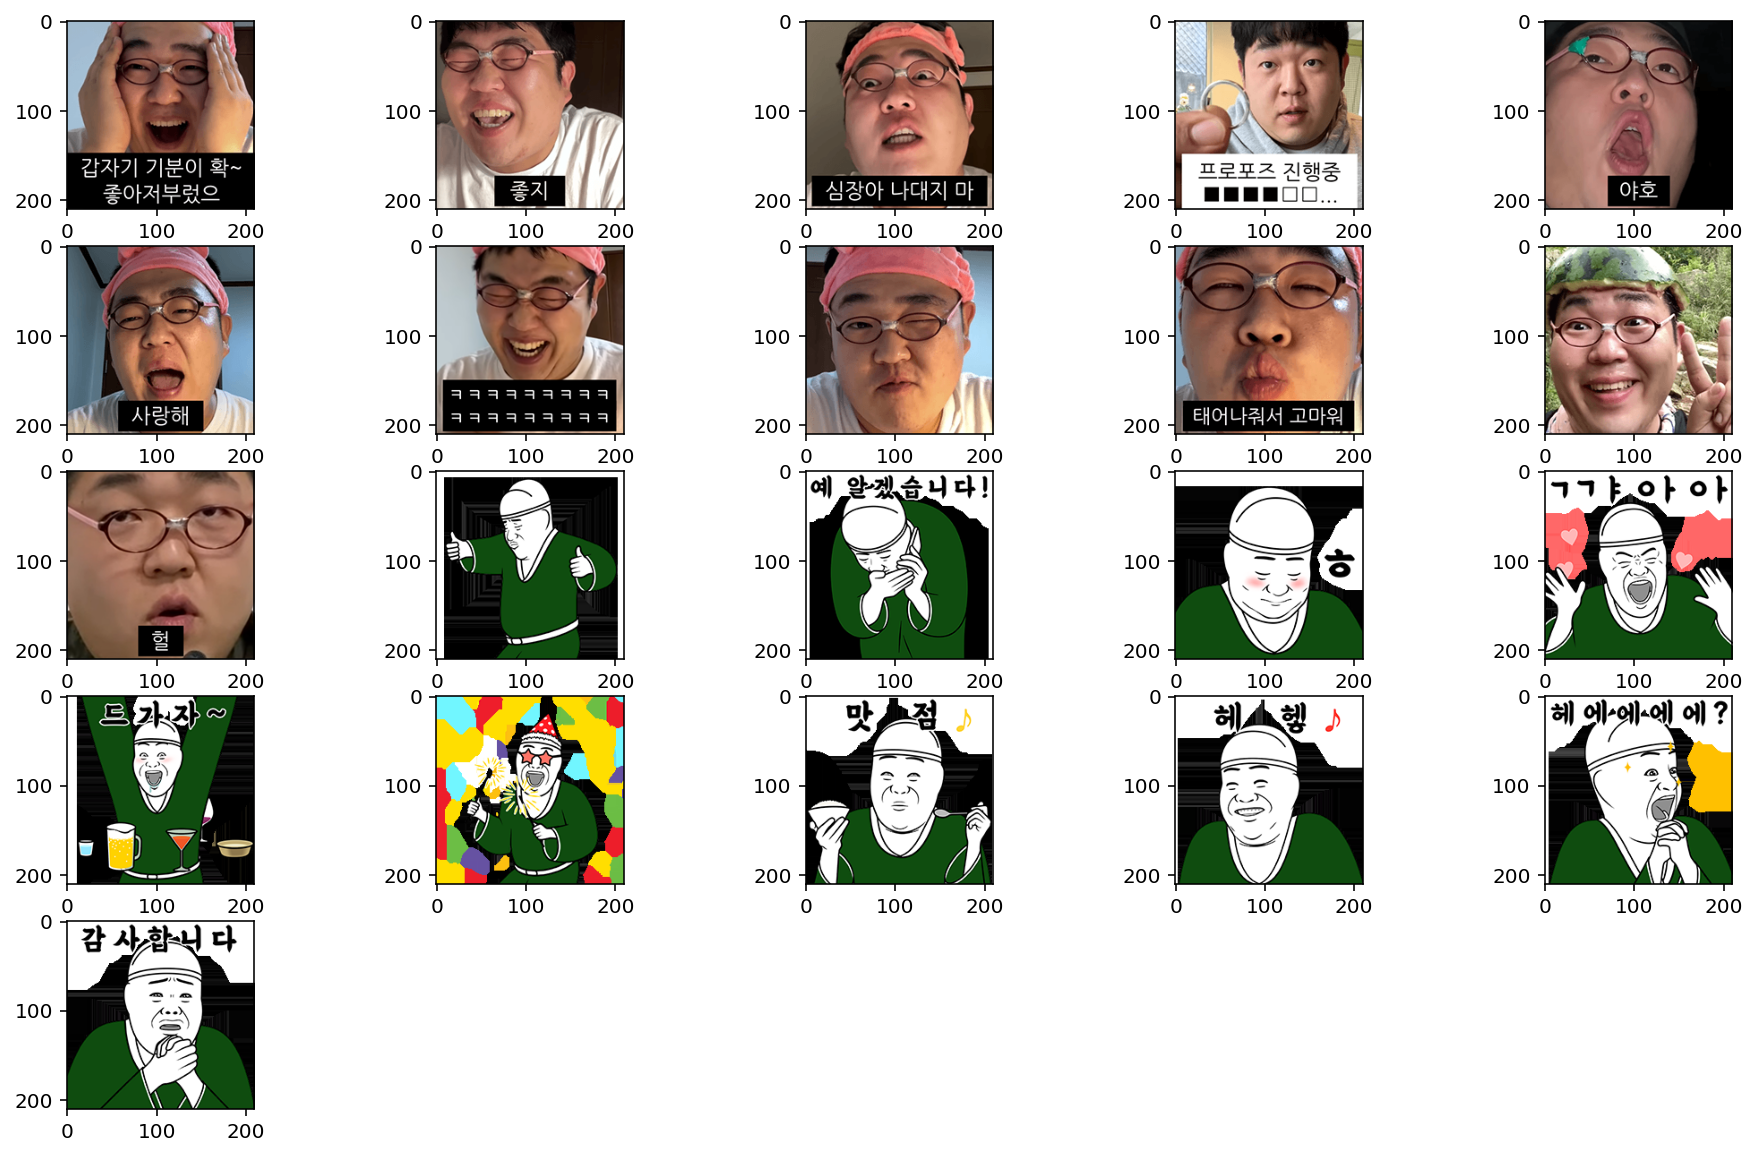

In [95]:
emoticons_list=sentiment_filtering.values.tolist()
plt.figure(figsize=(16, 10))
plt.axis('off')
for i in range(len(emoticons_list)) :
  dir=emoticons_classified_dir+emoticons_list[i][0]+'/'+str(emoticons_list[i][1])+'.png'
  img=Image.open(dir).convert("RGB")
  plt.subplot(5, len(emoticons_list)//5+1, i+1)
  plt.imshow(img)